In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('csvfiles/employee.csv')

df["exceeds_monthly_hours_threshold"] = np.where(df["average_montly_hours"] >= 160, 1, 0).astype(int)
df.exceeds_monthly_hours_threshold = df.exceeds_monthly_hours_threshold.astype('category')
df.left = df.left.astype("category")
df.number_project = df.number_project.astype("category")
df.time_spend_company = df.time_spend_company.astype("category")
df.Work_accident = df.Work_accident.astype("category")
df.promotion_last_5years = df.promotion_last_5years.astype("category")

Linear Regression:
MAE: 0.1579, MSE: 0.0413, R^2: 0.3370

K-Neighbors Regressor:
MAE: 0.1513, MSE: 0.0422, R^2: 0.3227

Decision Tree Regressor:
MAE: 0.1363, MSE: 0.0339, R^2: 0.4561

Lasso Regression:
MAE: 0.1818, MSE: 0.0477, R^2: 0.2343

Ridge Regression:
MAE: 0.1579, MSE: 0.0413, R^2: 0.3370

Сравнение моделей:
                              MAE       MSE       R^2
Linear Regression        0.157942  0.041298  0.337020
K-Neighbors Regressor    0.151281  0.042189  0.322722
Decision Tree Regressor  0.136333  0.033878  0.456131
Lasso Regression         0.181825  0.047694  0.234340
Ridge Regression         0.157944  0.041298  0.337020


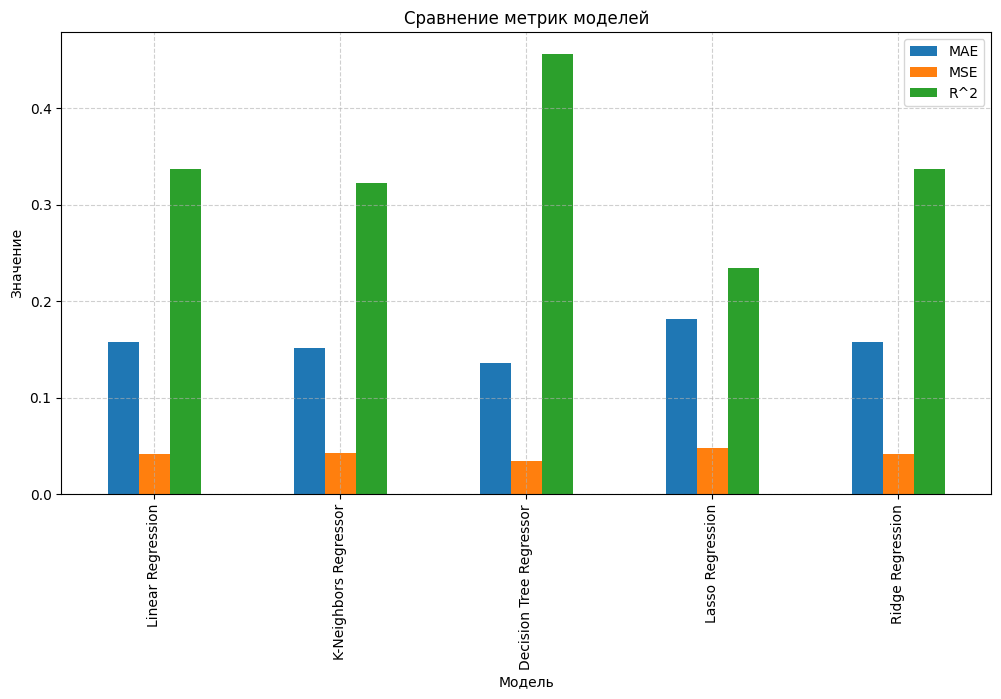

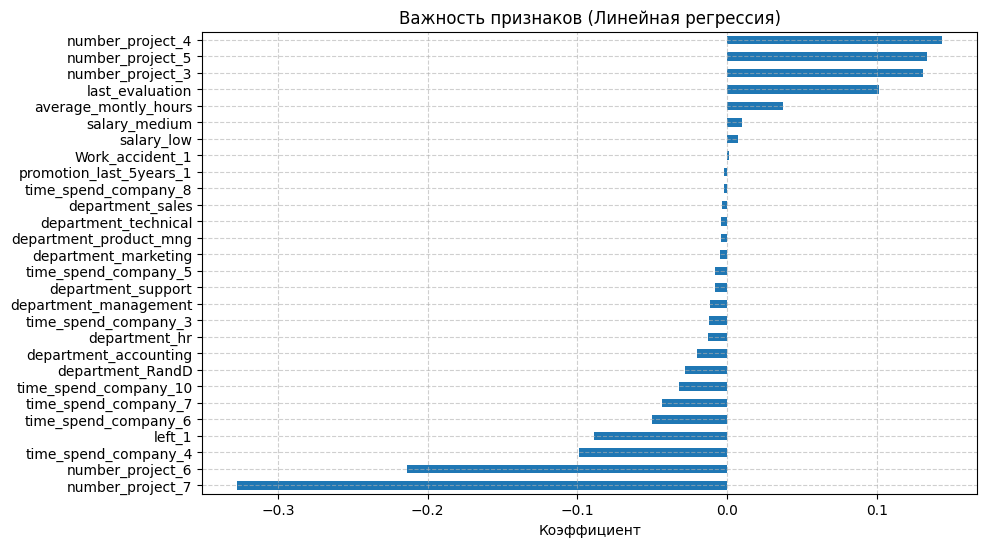

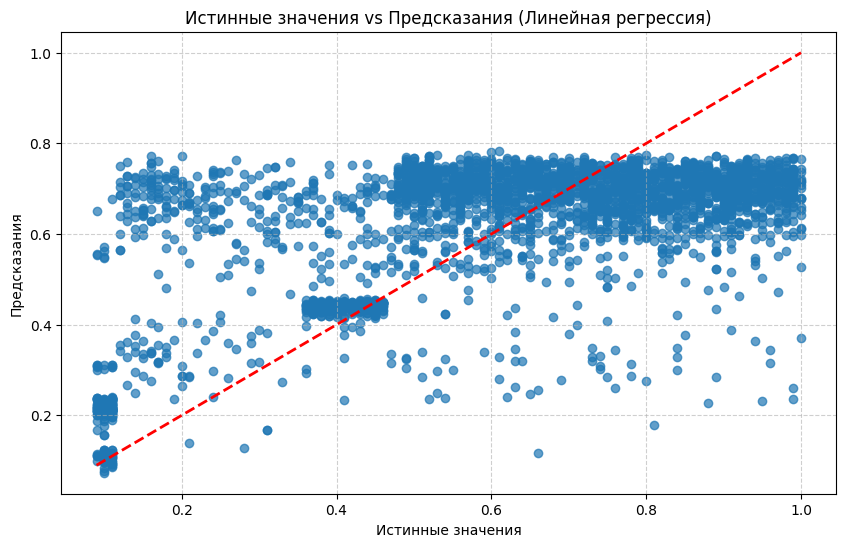

In [22]:
# 1. Выбор целевой переменной (y)


y = df['satisfaction_level']  # Непрерывная переменная
X = df.drop(columns=['satisfaction_level', 'exceeds_monthly_hours_threshold'], axis=1)  # Убираем ненужные столбцы

# 2. Предобработка данных
# Преобразование категориальных переменных в One-Hot Encoding
category_columns = X.select_dtypes(include=['category', 'object']).columns
X = pd.get_dummies(X, columns=category_columns, drop_first=True)

# Нормализация числовых признаков
numeric_features = X.select_dtypes(include=['float64', 'int']).columns
scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Разделение данных
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Отбор признаков
# Отбор признаков по корреляции
correlation = X.corrwith(y).abs()
top_features = correlation.nlargest(5).index
X_selected_corr = X[top_features]

# Отбор признаков с помощью RFE
model = LinearRegression()
selector = RFE(model, n_features_to_select=5, step=1)
selector.fit(X_train, y_train)
selected_features_rfe = X_train.columns[selector.support_]
X_selected_rfe = X[selected_features_rfe]

# Функция для оценки моделей
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}:\nMAE: {mae:.4f}, MSE: {mse:.4f}, R^2: {r2:.4f}\n")
    return {"MAE": mae, "MSE": mse, "R^2": r2}

# 4. Обучение моделей
results = {}

# Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
results['Linear Regression'] = evaluate(y_test, y_pred_linear, "Linear Regression")

# K-Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
results['K-Neighbors Regressor'] = evaluate(y_test, y_pred_knn, "K-Neighbors Regressor")

# Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
results['Decision Tree Regressor'] = evaluate(y_test, y_pred_tree, "Decision Tree Regressor")

# Lasso Regression
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
results['Lasso Regression'] = evaluate(y_test, y_pred_lasso, "Lasso Regression")

# Ridge Regression
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
results['Ridge Regression'] = evaluate(y_test, y_pred_ridge, "Ridge Regression")

# 5. Сравнение моделей
results_df = pd.DataFrame(results).T
print("Сравнение моделей:")
print(results_df)

# 6. Построение графиков

# График 1: Сравнение метрик моделей
results_df.plot(kind='bar', figsize=(12, 6))
plt.title("Сравнение метрик моделей")
plt.ylabel("Значение")
plt.xlabel("Модель")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# График 2: Важность признаков для линейной регрессии
feature_importance = pd.Series(linear_model.coef_, index=X_train.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Важность признаков (Линейная регрессия)")
plt.xlabel("Коэффициент")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# График 3: Предсказания vs Истинные значения (Linear Regression)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Истинные значения vs Предсказания (Линейная регрессия)")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказания")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()